# Cats vs Dogs

## Train and test the model

#### Imports

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 
import itertools
import os

In [2]:
path = "data/train"

#### Data preparation

Cada imagen es en realidad un conjunto de píxeles. El objetivo es convertir esos píxeles en un arreglo.
Para eso utilizamos cv2 (OpenCV-Python)

Todas las imagenes se encuentran en la carpeta "data" y cumplen con el formato "categoria.numero.formato"

In [3]:
X = []
y = []

Si la categoria es igual nombre indicado, entonces es 1. De otra forma es 0 (indica que pertenece a la otra categoria)

In [4]:
convert = lambda category : int(category == 'dog')

Definimos una funcion para crear nuestro arreglo con las imágenes preprocesadas (X) y nuestro arreglo de labels (y).

In [5]:
def create_test_data(path):
    for p in os.listdir(path):
        #Obtenemos la categoria del nombre del archivo
        category = p.split(".")[0]
        category = convert(category)
        
        #Leemos la imagen en escala de grises y convertimos los pixeles en un arreglo
        img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
        
        #Disminuimos el tamaño de la imagen
        new_img_array = cv2.resize(img_array, dsize=(100, 100))
        
        X.append(new_img_array)
        y.append(category)

Llamar a la funcion create_test_data

In [6]:
create_test_data(path)

Crear numpy arrays. Se hace reshape en X para que la forma de nuestros datos cumpla con los requisitos del parámetro "input_shape" en Conv2D (x_shape, y_shape, channels). La nueva dimensión es (número de imágenes, 100, 100, 1).

In [7]:
X = np.array(X).reshape(-1,100,100,1)
y = np.array(y)

Normalizar los datos: Los datos en X son valores que varian entre 0 y 255. Esto es porque cada pixel tiene una densidad disntinta de blanco y negro. Esto puede dificultar el aprendizaje del modelo. Para solucionarlo normalizamos los datos. Como sabemos que varian entre 0 y 255, podemos dividir por 255 y obtener valores entre 0 y 1.

In [8]:
X = X/255.0

Utilizamos train_test_split para dividir en conjunto de entrenamiento y conjunto de test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Model

Utilizamos el modelo Sequential de Keras donde se agrega de a una capa a la vez.

* La primera capa es la de convolución (Conv2D). En ella los parámetros que especificamos son:
    1. Número de filtros: 32
    2. Kernel_size: (3,3)
    3. Función de activación: Elegimos Relu
    4. Input_shape: (height, width, depth)
    
   
* La segunda capa es la de Pooling. Esta se utiliza para reducir el costo computacional y, hasta cierto punto, también reduce el overfitting.

* Luego agregamos otros conjuntos de capas de convolución y pooling con mayor cantidad de filtros.

* Agregamos la capa Flatten, la cual convierte los datos en una matriz unidimensional para ingresarlos en la siguiente capa.

* Agregamos la capa Dense (Fully connected neural network layer).

* Finalmente agregamos otra capa Dense, la cual tiene como output la predicción. Ponemos a la función sigmoide como función de activación

In [10]:
model = Sequential()

model.add(Conv2D(32,(3,3), activation = 'relu', input_shape = X_train.shape[1:]))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(256,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

Parámetros al compilar:

* optimizer: Elegimos el algoritmo adam, pero se pueden utilizar otros como SGD o RMSprop.
* loss: Debido a que tenemos dos posibles resultados, utilizamos binary_crossentropy.
* metrics: Métrica para medir el modelo.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         2

Entrenamos el modelo. Parámetros:

    Epochs: Cuantas veces el modelo pasa por el conjunto de entrenamiento.
    Batch size: La cantidad de datos a la vez que se desea pasar por el modelo.
    validation_split: Se encarga de separar conjunto de entrenamiento y de validacion automaticamente (en este caso 20%)

In [12]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
500/500 [==============================] - 175s 350ms/step - loss: 0.6569 - accuracy: 0.6012 - val_loss: 0.6081 - val_accuracy: 0.6785
Epoch 2/10
500/500 [==============================] - 174s 348ms/step - loss: 0.5459 - accuracy: 0.7226 - val_loss: 0.5044 - val_accuracy: 0.7515
Epoch 3/10
500/500 [==============================] - 173s 347ms/step - loss: 0.4547 - accuracy: 0.7822 - val_loss: 0.4281 - val_accuracy: 0.7937
Epoch 4/10
500/500 [==============================] - 173s 347ms/step - loss: 0.3803 - accuracy: 0.8266 - val_loss: 0.3930 - val_accuracy: 0.8245
Epoch 5/10
500/500 [==============================] - 174s 348ms/step - loss: 0.3233 - accuracy: 0.8597 - val_loss: 0.3692 - val_accuracy: 0.8460
Epoch 6/10
500/500 [==============================] - 168s 336ms/step - loss: 0.2744 - accuracy: 0.8844 - val_loss: 0.3866 - val_accuracy: 0.8378
Epoch 7/10
500/500 [==============================] - 167s 334ms/step - loss: 0.2238 - accuracy: 0.9082 - val_loss: 0.3849 -

Guardamos el modelo

In [13]:
model.save("model.h5")

Realizamos las predicciones

In [14]:
predictions = model.predict(X_test)

Redondeamos los valores ya que usamos la función sigmoide y obtuvimos los valores de probabilidad en nuestras predicciones

In [15]:
y_pred = []

In [16]:
def round_y_pred():
    for p in predictions:
        p = p.round()
        y_pred.append(p)  

In [17]:
round_y_pred()

#### Model Evaluation

Utilizamos scikit para realizar el reporte de clasificación, el cual nos muestra la precisión, recall y f1-score

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      2507
           1       0.86      0.84      0.85      2493

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



Realizamos la matriz de confusión y la imprimimos

In [19]:
c_matrix = confusion_matrix(y_test, y_pred)

In [20]:
c_matrix

array([[2167,  340],
       [ 399, 2094]], dtype=int64)

Función para plotear la matriz de confusión

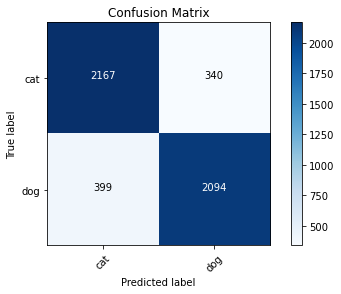

In [21]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)   

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['cat','dog']   
plot_confusion_matrix(cm=c_matrix, classes=cm_plot_labels, title='Confusion Matrix')

## Making predictions

In [22]:
model = models.load_model('model.h5')

In [23]:
path_test_data = "data/test1"

In [24]:
X = []
image_name = []

In [25]:
def create_unlabeled_data(path):
    for p in os.listdir(path):
        image_name.append(p)
        #Leemos la imagen en escala de grises y convertimos los pixeles en un arreglo
        img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)        
        #Disminuimos el tamaño de la imagen
        new_img_array = cv2.resize(img_array, dsize=(100, 100))        
        X.append(new_img_array)

In [26]:
create_unlabeled_data(path_test_data)

In [27]:
#Creamos numpy arrays
X_test = np.array(X).reshape(-1,100,100,1)

#Normalizamos
X_test = X_test/255.0

In [28]:
predictions = model.predict(X_test)

El razonamiento es el siguiente: Mientras el resultado de predictions sea mas cercano a 0, entonces es cat. Mientras sea mas cercano a 1, es dog. Si la red no está lo suficientemente segura, entonces lo clasificamos como otro.

In [29]:
def round_percetenges():
    for p in predictions:
        #print(p)
        if p > 0.35  and p < 0.80:
            p = [2.0] 
        else:
            p = p.round()
            
        y_pred.append(p) 

In [30]:
y_pred = []
round_percetenges()

Imprimimos los resultados (0 = Cat, 1 = Dog, 2 = Other)

In [31]:
#for i in range(len(y_pred)):
#Imprimimos los primeros 10 como prueba
for i in range(10):
    #print("Imagen:" , image_name[i] , "- Prediccion:" , y_pred[i][0], "   -Porcentaje", predictions[i][0], "%")
    if y_pred[i][0] == 0.0:
        print("Imagen:" , image_name[i] , "- Prediccion: Cat   -Porcentaje", predictions[i][0], "%")
    elif y_pred[i][0] == 1.0:
        print("Imagen:" , image_name[i] , "- Prediccion: Dog  -Porcentaje", predictions[i][0], "%")
    else:
        print("Imagen:" , image_name[i] , "- Prediccion: Other -Porcentaje", predictions[i][0], "%")

Imagen: 1.jpg - Prediccion: Cat   -Porcentaje 0.09946391 %
Imagen: 10.jpg - Prediccion: Cat   -Porcentaje 2.156303e-06 %
Imagen: 100.jpg - Prediccion: Cat   -Porcentaje 0.060059875 %
Imagen: 1000.jpg - Prediccion: Dog  -Porcentaje 0.99809885 %
Imagen: 10000.jpg - Prediccion: Dog  -Porcentaje 0.99438155 %
Imagen: 10001.jpg - Prediccion: Cat   -Porcentaje 0.0031434596 %
Imagen: 10002.jpg - Prediccion: Cat   -Porcentaje 0.01936227 %
Imagen: 10003.jpg - Prediccion: Dog  -Porcentaje 0.99990684 %
Imagen: 10004.jpg - Prediccion: Dog  -Porcentaje 0.9809032 %
Imagen: 10005.jpg - Prediccion: Cat   -Porcentaje 3.268776e-08 %
